In [1]:
from ipywidgets import interact, interact_manual

%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings

# Convolutional Neural Tangent Kernels

Various papers have shown that, in the infinite width limit, any _Neural Network_ with _standard architecture_ is equivalent to a Gaussian process at initialization. Furthermore, Jacot and Al. have introduced the concept of _Neural Tangent Kernel_ and proved that for MLP, it stays constant during training.

Although, for MLPs, regression based on NTK obtains results equivalent, or even better, than those of the original network, the same does not holds for CNNs, where experimental results show that the actual network greatly outperform the kernel methods.

We investigate in this notebook the reason for that behaviour. In particular, we focus on what the network is actually learning, to confront it with what the NTK gives as a function.

## The experiment

We consider different network architectures and, for each, we study the learning of a Neural Network $NN$ randomly initialized.
It is proved in [yang2019scaling] that, in the infinite width limit (IWL), each such Network is equivalent at initialization to a Gaussian Precess.
Furthermore, [jacot2019neural] proved that in the MLP case during training, the gradient follow the Neural Tangent Kernel, which in the IWL is constant and converges.
We conjecture that the same should hold for any architecture and study what the actual Net learns compared to the infinite width limit.

In particular, we consider for each $NN$ at initialization, the actual Neural Tangent Kernel $$???$$ which we denote by $NTK^P_0$ and its theoretical-infinite-wide counterpart $NTK^\infty$.

We then train the Net to get $NN_\infty$ and its corresponding $NTK^P_\infty$.
By [jacot2019neural], we know that $NTK^\infty$ does not change during training, so we can study the kernel regression functions $f^P_\infty$ and $f^\infty$ given respectively by the finite-case Tangent Kernel and the infinte-width one.
Note that the subscript $\infty$ refers to the training, while the superscript one refers to the number of parameters.

We expect the $f^M_\infty$ to be very close to the actual Net output $NN_\infty$ and we want to understand the difference between it and the infinite width kernel regression function.

We use **Pythorch** as our deep learning framework.

In [3]:
warnings.simplefilter('ignore')

import torch
import torchvision

import torch.nn as nn
import torch.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.autonotebook import tqdm

from utility.train import train
from utility.metrics import print_score, nn_accuracy_score

In [4]:
seed = 201911181557

torch.backends.cudnn.enabled = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## The dataset

To start, we work with the **MNIST** dataset, to investigate what the CNN kernel learns. When working with transformers we will use a semantic dataset **TBD**

The MNIST dataset consist in grayscale images of handwritten digits, whose size is 28x28 pixels.

We use 1000 samples for train and we study the Kernel on a test of 100 samples, representing each class (digit).

In [5]:
train_size = 100
test_size= 100

In [6]:
transform =torchvision.transforms.Compose([
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(
                  (0.1307,), (0.3081,))
                  ])

In [7]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../../data/', train=True, download=True,
                             transform=transform),
  batch_size=train_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../../data/', train=False, download=True,
                             transform=transform),
  batch_size=test_size, shuffle=True)

Note that the values $0.1307$ and $0.3081$ are the well known mean and variance for the MNIST dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


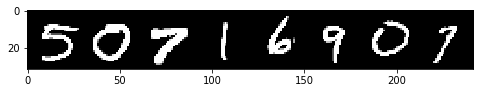

    5     0     7     1     6     9     0     7


In [8]:
def imshow(img):
    img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.figure(figsize = (8,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

ordered_labels = labels.argsort()

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(8)))

In [9]:
testiter = iter(test_loader)
images_test, labels_test = testiter.next()

## The Multi Layer Perceptron

We use a simple design, to warm up the computations. The derivation of the NTK is then based on [arora2019exact].

We use an MLP with ? layers and ReLU activation function, and try a different number of hidden nodes.

In [10]:
import copy

def compute_kernel_slow(X, net):
    net.zero_grad()
    net1 = copy.deepcopy(net)
    out = net(X)

    n_samples, dim_out = out.shape

    kernel = torch.zeros([n_samples * dim_out] * 2, dtype=torch.float)
    
    with torch.no_grad():
        for x in range(n_samples):
            for x1 in range(x, n_samples):
                for i in range(dim_out):
                    for j in range(i, dim_out):
                        direction = torch.zeros_like(out, dtype=torch.float)
                        direction[x, i] = 1.
                        Jac = torch.autograd.grad(out, net.parameters(), direction, retain_graph=True)
                   
                        direction = torch.zeros_like(out, dtype=torch.float)
                        direction[x1, j] = 1.
                        Jac1 = torch.autograd.grad(out, net.parameters(), direction, retain_graph=True)
                        
                        kernelValue = 0.
                        for grad, grad1 in zip(Jac, Jac1):
                            kernelValue += torch.sum(grad * grad1)
                        
                        kernel[dim_out * x + i, dim_out * x1 + j] = kernelValue
                        kernel[dim_out * x1 + j, dim_out * x + i] = kernelValue
    
    return kernel

44860


In [57]:
import copy

def compute_kernel(X, net, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        net = net.to(device)
        X = X.to(device)

    net.zero_grad()
    out = net(X)

    n_samples, dim_out = out.shape
    n_params = sum(par.numel() for par in MLP.parameters() if par.requires_grad)

    kernel = torch.zeros([n_samples * dim_out] * 2, dtype=torch.float).to(device)
    
    with torch.no_grad():
        # compute the jacobians
        Jac = torch.zeros(n_samples, dim_out, n_params)
        for x in tqdm(range(n_samples), desc='Compute the jacobians'):
            for i in range(dim_out):
                direction = torch.zeros_like(out, dtype=torch.float)
                direction[x, i] = 1.
                # Note, if we manage to flatten in one tensor each dic entry, we can use it a tensor as well.
                JacList = torch.autograd.grad(out, net.parameters(), direction, retain_graph=True)
                
                Jac[x, i] = torch.cat(tuple(map(lambda par: par.reshape(-1) , JacList)))
                
                
        # compute the kernel value
        for x in tqdm(range(n_samples), desc='Compute the kernel'):
            for x1 in range(x, n_samples):
                for i in range(dim_out):
                    for j in range(dim_out):
                        kernelValue = torch.sum(Jac[x,i] * Jac[x1, j])
                        
                        kernel[dim_out * x + i, dim_out * x1 + j] = kernelValue
                        kernel[dim_out * x1 + j, dim_out * x + i] = kernelValue
    
    return kernel

In [58]:
n_hidden_nodes = 50

MLP = nn.Sequential(nn.Flatten(), nn.Linear(784, n_hidden_nodes),
                    nn.Linear(n_hidden_nodes, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, n_hidden_nodes), nn.ReLU(),
                    nn.Linear(n_hidden_nodes, 10))

In [59]:
%%time
kernel = compute_kernel(images, MLP)

CPU times: user 2min 45s, sys: 764 ms, total: 2min 46s
Wall time: 42.3 s


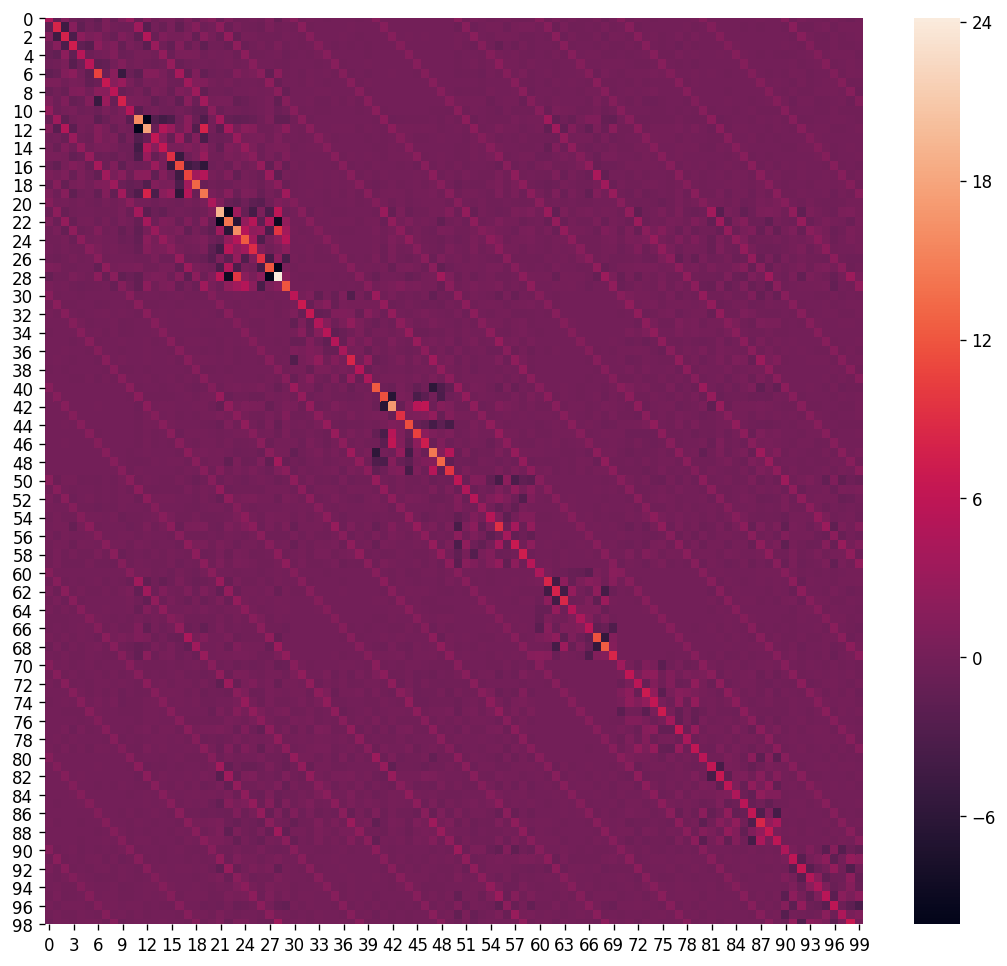

In [60]:
fig, ax = plt.subplots(figsize=(11,10), dpi=120)
sns.heatmap(kernel[:100,:100].cpu(), ax=ax)
plt.show()

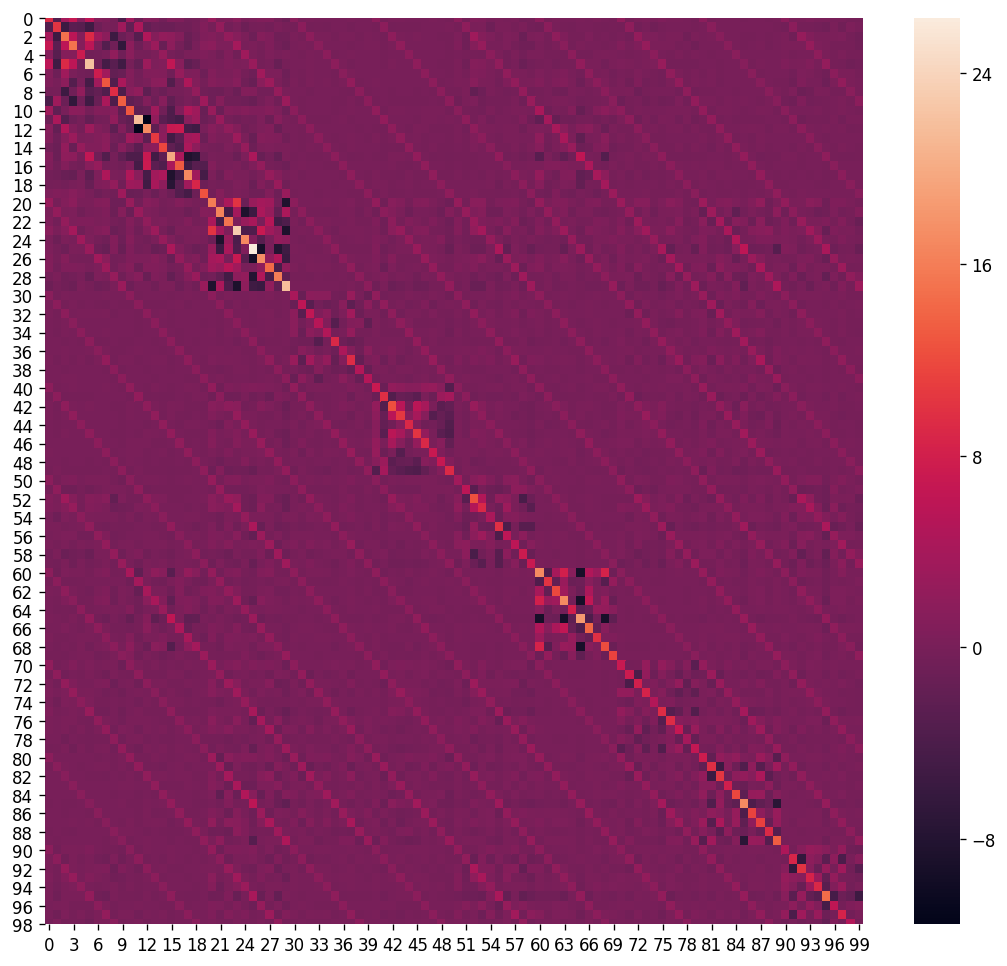

In [25]:
fig, ax = plt.subplots(figsize=(11,10), dpi=120)
sns.heatmap(kernel[:100,:100].cpu(), ax=ax)
plt.show()

In [12]:
MLP.zero_grad()
out = MLP(images)

In [114]:
mat1

tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015],
        ...,
        [ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  0.0014],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015]])

In [31]:
optimizer = torch.optim.SGD(MLP.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(MLP.parameters())
criterion = torch.nn.CrossEntropyLoss()
    
MLP_t = train(MLP, images, labels, criterion, optimizer, nb_epochs=5000)

In [32]:
print_score(MLP, criterion, images, labels, images_test, labels_test)
print_score(MLP, nn_accuracy_score, images, labels, images_test, labels_test)

CrossEntropyLoss() on TRAIN :	 0.0023235795088112354 
CrossEntropyLoss() on TEST :	 1.8443427085876465
<function nn_accuracy_score at 0x7f3134033e60> on TRAIN :	 0.9990000128746033 
<function nn_accuracy_score at 0x7f3134033e60> on TEST :	 0.8199999928474426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


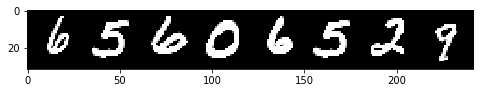

Label :		 6 5 6 0 6 5 2 9
Prediction :	 6 5 6 0 6 5 2 9


In [34]:
random_idcs = [np.random.randint(100) for _ in range(8)]
# show images
imshow(torchvision.utils.make_grid(images_test[random_idcs]))
# print labels
print('Label :\t\t', *(labels_test[j].item() for j in random_idcs))
print('Prediction :\t', *(MLP(images_test)[j].argmax().item() for j in random_idcs))